In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

from functools import partial
from scipy.optimize import bisect, brentq, newton
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, TheilSenRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

1. Исходные данные

In [2]:
# Фиксация генератора случайных чисел
random_seed = 1901
np.random.seed(random_seed)

# Значения предикторов для прогноза целевой переменной
A_complex_max = [1800 + 1000j, 1500 + 1000j, 1800 + 1400j, 2000 + 1700j, 1500 + 1200j]
# A_complex_max = [600 + 200j, 240 + 170j, 700 + 320j, 800 + 300j, 400 + 150j]

# Относительный размер тестовой выборки
test_size = 0.3

2. Загрузка датасетов

In [3]:
# Загрузка точных коэффициентов регрессии (для контроля обучения моделей)
z_complex_acc = pd.read_excel('C:\Datasets/dataset_z_complex_acc.xlsx').astype(complex)
z_complex_acc.T

,0,1,2,3,4
0,0.04+0.02j,0.035+0.015j,0.03+0.02j,0.020+0.012j,0.016+0.010j


In [4]:
# Загрузка датасета с данными из комплексных чисел
df_complex = pd.read_excel('C:\Datasets/dataset_complex_2.xlsx').astype(complex)
df_complex

,A_h_1,A_h_2,A_h_3,A_h_4,A_h_5,b_d
0,400.005510+150.002066j,199.983094+99.991547j,450.009763+200.004339j,600.047700+250.019875j,200.001796+100.000898j,39.200583+51.300763j
1,402.938265+151.101849j,202.688356+101.344178j,454.384083+201.948481j,608.095781+253.373242j,202.172245+101.086122j,39.609082+51.842365j
2,407.962003+152.985751j,205.221697+102.610848j,460.031711+204.458538j,616.833743+257.014060j,203.271658+101.635829j,40.099123+52.479623j
3,410.969392+154.113522j,206.256335+103.128168j,464.319915+206.364407j,625.855804+260.773252j,203.589493+101.794747j,40.461510+52.959228j
4,415.540179+155.827567j,207.158071+103.579035j,466.439858+207.306604j,632.881856+263.700773j,203.629064+101.814532j,40.784552+53.361314j
...,...,...,...,...,...,...
95,813.541376+305.078016j,416.768048+208.384024j,922.382835+409.947926j,1184.038236+493.349265j,434.087584+217.043792j,79.910514+104.655848j
96,819.693973+307.385240j,417.759601+208.879801j,929.971135+413.320505j,1185.080138+493.783391j,439.793498+219.896749j,80.369566+105.271201j
97,820.985581+307.869593j,421.845996+210.922998j,937.403074+416.623588j,1191.294097+496.372541j,444.896390+222.448195j,80.826875+105.910570j
98,828.149318+310.555994j,426.798587+213.399293j,947.137400+420.949956j,1204.144831+501.727013j,446.897548+223.448774j,81.619901+106.949367j


3. Попарные графики рассеяния модулей значений переменных датасета

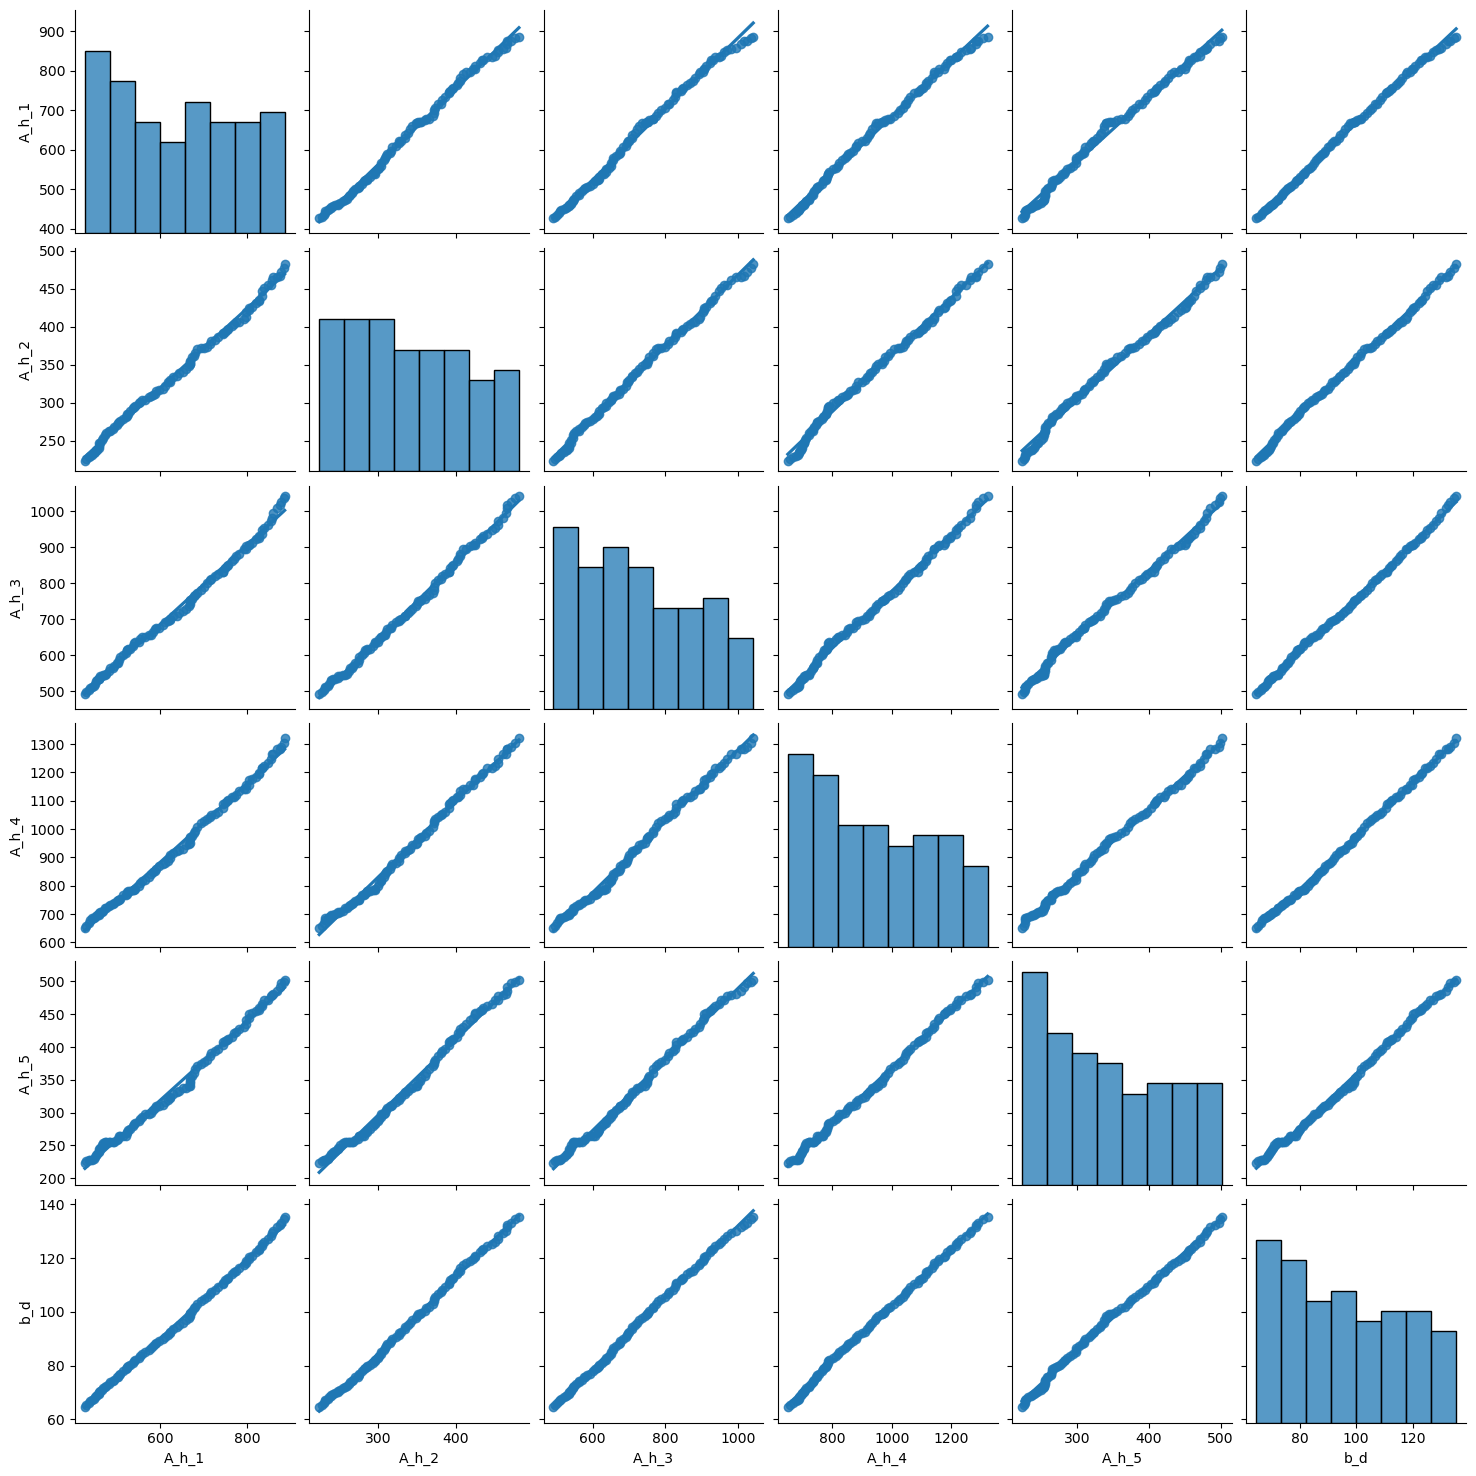

In [5]:
df_modul = df_complex.applymap(lambda x: abs(x))
sns.pairplot(df_modul, kind="reg")
plt.show()

4. Выделение комплексной матрицы признаков и комплексного вектора целевой переменной из датасета df_complex

In [6]:
A_complex = df_complex.iloc[:, :-1].values
b_complex = df_complex.iloc[:, -1].values
cond_A_complex = np.linalg.cond(A_complex.T @ A_complex)
det_A_complex = np.linalg.det(A_complex.T @ A_complex)

print(f'Число обусловленности матрицы A_complex: cond(A_complex) = {cond_A_complex.round(1)}')
print("Определитель матрицы A_complex:", det_A_complex)

Число обусловленности матрицы A_complex: cond(A_complex) = 235065.1
Определитель матрицы A_complex: (-6.151358471088519e+22-1.0888891549400429e+23j)


5. Разбиение на обучающую и тестовые выборки

In [7]:
A_train_complex, A_test_complex, b_train_complex, b_test_complex = train_test_split(A_complex, 
                                                                                    b_complex,
                                                                                    test_size=test_size,
                                                                                    random_state=random_seed)

6. Формирование вещественной матрицы A_train признаков и вещественного вектора b_train целевой переменной

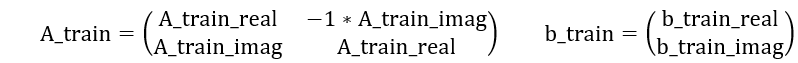


In [8]:
A_train_real = A_train_complex.real
A_train_imag = A_train_complex.imag
A_train_1 = pd.concat([pd.DataFrame(A_train_real), pd.DataFrame(A_train_imag)], axis=0)
A_train_2 = pd.concat([-1 * pd.DataFrame(A_train_imag), pd.DataFrame(A_train_real)], axis=0)
index_train = np.arange(A_train_1.shape[0])
A_train_1.index = index_train
A_train_2.index = index_train 
A_train = pd.merge(A_train_1, A_train_2, left_index=True, right_index=True)
A_train.columns = [f'A_{i+1}' for i in range(A_train.shape[1])]

In [9]:
b_train_real = b_train_complex.real
b_train_imag = b_train_complex.imag
b_train = pd.concat([pd.DataFrame(b_train_real), pd.DataFrame(b_train_imag)], axis=0)
b_train.index = index_train
b_train.columns = ['b']

7. Формирование вещественной матрицы A_test признаков и вещественного вектора b_test целевой переменной

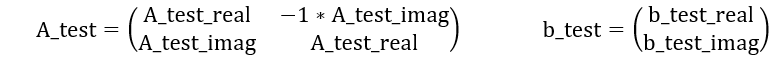

In [10]:
A_test_real = A_test_complex.real
A_test_imag = A_test_complex.imag
A_test_1 = pd.concat([pd.DataFrame(A_test_real), pd.DataFrame(A_test_imag)], axis=0)
A_test_2 = pd.concat([-1 * pd.DataFrame(A_test_imag), pd.DataFrame(A_test_real)], axis=0)
index_test = np.arange(A_test_1.shape[0])
A_test_1.index = index_test
A_test_2.index = index_test 
A_test = pd.merge(A_test_1, A_test_2, left_index=True, right_index=True)
A_test.columns = [f'A_{i+1}' for i in range(A_test.shape[1])]

In [11]:
b_test_real = b_test_complex.real
b_test_imag = b_test_complex.imag
b_test = pd.concat([pd.DataFrame(b_test_real), pd.DataFrame(b_test_imag)], axis=0)
b_test.index = index_test
b_test.columns = ['b']

8. Формирование вещественного вектора A_max для прогноза целевой переменной

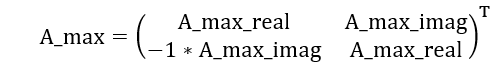

In [12]:
A_max_real = np.array(A_complex_max).real
A_max_imag = np.array(A_complex_max).imag
A_max_1 = pd.concat([pd.DataFrame(A_max_real), -1 * pd.DataFrame(A_max_imag)], axis=0)
A_max_2 = pd.concat([pd.DataFrame(A_max_imag), pd.DataFrame(A_max_real)], axis=0)
index_max = np.arange(A_max_1.shape[0])
A_max_1.index = index_max
A_max_2.index = index_max 
A_max = pd.merge(A_max_1, A_max_2, left_index=True, right_index=True)
A_max = A_max.T
A_max

,0,1,2,3,4,5,6,7,8,9
0_x,1800.0,1500.0,1800.0,2000.0,1500.0,-1000.0,-1000.0,-1400.0,-1700.0,-1200.0
0_y,1000.0,1000.0,1400.0,1700.0,1200.0,1800.0,1500.0,1800.0,2000.0,1500.0


9. Масштабирование признаков и вектора A_max

In [13]:
sc = MaxAbsScaler()    # MaxAbsScaler()    StandardScaler()

# Переход к привычным обозначениям X и y для признаков и целевых переменных
X_train_std = sc.fit_transform(A_train) 
X_test_std = sc.transform(A_test)
# X_train_std = A_train 
# X_test_std = A_test

y_train = b_train
y_test = b_test

In [14]:
A_max_std = sc.transform(A_max)
# A_max_std = A_max
pd.DataFrame(A_max_std).round(3)

,0,1,2,3,4,5,6,7,8,9
0,2.169,3.48,1.889,1.640,3.343,-1.205,-2.32,-1.470,-1.394,-2.675
1,1.205,2.32,1.470,1.394,2.675,2.169,3.48,1.889,1.640,3.343


10. Обучение моделей регрессоров на train-данных

In [15]:
metrics = {}

10.1 LinearRegression

In [16]:
lr = LinearRegression()
model_lr = lr.fit(X_train_std, y_train)

y_lr_pred = model_lr.predict(X_test_std)
y_lr_pred_train = model_lr.predict(X_train_std)

rmse_lr_train = np.sqrt(mean_squared_error(y_train, y_lr_pred_train)).round(3)
rmse_lr_test = np.sqrt(mean_squared_error(y_test, y_lr_pred)).round(3)
mae_lr_train = mean_absolute_error(y_train, y_lr_pred_train).round(3)
mae_lr_test = mean_absolute_error(y_test, y_lr_pred).round(3)
r2_lr_train = r2_score(y_train, y_lr_pred_train).round(3)
r2_lr_test = r2_score(y_test, y_lr_pred).round(3)

b_max_lr = model_lr.predict(A_max_std)[:].flatten()
b_max_lr_complex = complex(b_max_lr[0], b_max_lr[1])
b_max_lr_modul = np.abs(b_max_lr_complex)
b_max_lr_arg = np.angle(b_max_lr_complex) * 180 / np.pi
metrics['LinearRegr'] = (str(r2_lr_train), str(r2_lr_test), np.round(b_max_lr_complex, 1), str(b_max_lr_modul.round(1)), str(b_max_lr_arg.round(1)))

print(f'RMSE train: {rmse_lr_train}')
print(f'RMSE test:  {rmse_lr_test}')
print()
print(f'MAE train:  {mae_lr_train}')
print(f'MAE test:   {mae_lr_test}')
print()
print(f'R2 train:   {r2_lr_train}')
print(f'R2 test:    {r2_lr_test}')
print()
print(f'Прогноз целевой переменной:')
print(f'b max_complex: {np.round(b_max_lr_complex, 1)}')
print(f'b max_modul:   {b_max_lr_modul.round(1)}')
print()
print(f'Свободный член регрессии  a0 =  {model_lr.intercept_.round(3)}')
print('Масштабированные коэффициенты регрессии:')
pd.DataFrame({'z_real': model_lr.coef_.flatten()[:len(A_complex_max)], 'z_imag': model_lr.coef_.flatten()[len(A_complex_max):]}).T.round(1)

RMSE train: 0.004
RMSE test:  0.004

MAE train:  0.004
MAE test:   0.004

R2 train:   1.0
R2 test:    1.0

Прогноз целевой переменной:
b max_complex: (147.3+303.9j)
b max_modul:   337.7

Свободный член регрессии  a0 =  [0.018]
Масштабированные коэффициенты регрессии:


,0,1,2,3,4
z_real,33.2,15.1,28.5,24.2,7.3
z_imag,16.6,6.5,19.0,14.6,4.5


10.2 Ridge

In [17]:
rid = Ridge()
rid_parameters = {'alpha': np.logspace(-5, 3, num=101), 
                  'random_state':[1, 7, 42, 100]
}
model_rid = GridSearchCV(estimator=rid,
                   param_grid=rid_parameters,
                   scoring='r2', # 'neg_mean_absolute_error'
                   n_jobs=-1,
                   cv=5)
model_rid.fit(X_train_std, y_train)

y_rid_pred = model_rid.predict(X_test_std)
y_rid_pred_train = model_rid.predict(X_train_std)

rmse_rid_train = np.sqrt(mean_squared_error(y_train, y_rid_pred_train)).round(3)
rmse_rid_test = np.sqrt(mean_squared_error(y_test, y_rid_pred)).round(3)
mae_rid_train = mean_absolute_error(y_train, y_rid_pred_train).round(3)
mae_rid_test = mean_absolute_error(y_test, y_rid_pred).round(3)
r2_rid_train = r2_score(y_train, y_rid_pred_train).round(3)
r2_rid_test = r2_score(y_test, y_rid_pred).round(3)

b_max_rid = model_rid.predict(A_max_std)[:].flatten()
b_max_rid_complex = complex(b_max_rid[0], b_max_rid[1])
b_max_rid_modul = np.abs(b_max_rid_complex)
b_max_rid_arg = np.angle(b_max_rid_complex) * 180 / np.pi
metrics['Ridge'] = (str(r2_rid_train), str(r2_rid_test), np.round(b_max_rid_complex, 1), str(b_max_rid_modul.round(1)), str(b_max_rid_arg.round(1)))

print(f'RMSE train: {rmse_rid_train}')
print(f'RMSE test:  {rmse_rid_test}')
print()
print(f'MAE train:  {mae_rid_train}')
print(f'MAE test:   {mae_rid_test}')
print()
print(f'R2 train:   {r2_rid_train}')
print(f'R2 test:    {r2_rid_test}')
print()
print(f'Прогноз целевой переменной:')
print(f'b max_complex: {np.round(b_max_rid_complex, 1)}')
print(f'b max_modul:   {b_max_rid_modul.round(1)}')
model_rid.best_params_

RMSE train: 0.004
RMSE test:  0.005

MAE train:  0.004
MAE test:   0.004

R2 train:   1.0
R2 test:    1.0

Прогноз целевой переменной:
b max_complex: (147.4+304.1j)
b max_modul:   337.9


{'alpha': 1e-05, 'random_state': 1}

10.3 Lasso

In [18]:
lass = Lasso()
lass_parameters = {'alpha': np.logspace(-5, 3, num=101), 
                  'random_state':[1, 7, 42, 100]
}
model_lass = GridSearchCV(estimator=lass,
                   param_grid=lass_parameters,
                   scoring='r2', # 'neg_mean_absolute_error'
                   n_jobs=-1,
                   cv=5)
model_lass.fit(X_train_std, y_train)

y_lass_pred = model_lass.predict(X_test_std)
y_lass_pred_train = model_lass.predict(X_train_std)

rmse_lass_train = np.sqrt(mean_squared_error(y_train, y_lass_pred_train)).round(3)
rmse_lass_test = np.sqrt(mean_squared_error(y_test, y_lass_pred)).round(3)
mae_lass_train = mean_absolute_error(y_train, y_lass_pred_train).round(3)
mae_lass_test = mean_absolute_error(y_test, y_lass_pred).round(3)
r2_lass_train = r2_score(y_train, y_lass_pred_train).round(3)
r2_lass_test = r2_score(y_test, y_lass_pred).round(3)

b_max_lass = model_lass.predict(A_max_std)[:].flatten()
b_max_lass_complex = complex(b_max_lass[0], b_max_lass[1])
b_max_lass_modul = np.abs(b_max_lass_complex)
b_max_lass_arg = np.angle(b_max_lass_complex) * 180 / np.pi
metrics['Lasso'] = (str(r2_lass_train), str(r2_lass_test), np.round(b_max_lass_complex, 1), str(b_max_lass_modul.round(1)), str(b_max_lass_arg.round(1)))

print(f'RMSE train: {rmse_lass_train}')
print(f'RMSE test:  {rmse_lass_test}')
print()
print(f'MAE train:  {mae_lass_train}')
print(f'MAE test:   {mae_lass_test}')
print()
print(f'R2 train:   {r2_lass_train}')
print(f'R2 test:    {r2_lass_test}')
print()
print(f'Прогноз целевой переменной:')
print(f'b max_complex: {np.round(b_max_lass_complex, 1)}')
print(f'b max_modul:   {b_max_lass_modul.round(1)}')
model_lass.best_params_

RMSE train: 0.293
RMSE test:  0.304

MAE train:  0.202
MAE test:   0.216

R2 train:   1.0
R2 test:    1.0

Прогноз целевой переменной:
b max_complex: (201+322.3j)
b max_modul:   379.8


{'alpha': 0.003019951720402016, 'random_state': 1}

10.4 ElasticNet

In [19]:
en = ElasticNet()
en_parameters = {'alpha': np.logspace(-5, 3, num=101),
                 'l1_ratio': (0.05, 0.1, 0.3, 0.5, 0.7, 0.9),
                 'random_state':[1, 7, 42, 100]
}
model_en = GridSearchCV(estimator=en,
                   param_grid=en_parameters,
                   scoring='r2', # 'neg_mean_absolute_error'
                   n_jobs=-1,
                   cv=5)
model_en.fit(X_train_std, y_train)

y_en_pred = model_en.predict(X_test_std)
y_en_pred_train = model_en.predict(X_train_std)

rmse_en_train = np.sqrt(mean_squared_error(y_train, y_en_pred_train)).round(3)
rmse_en_test = np.sqrt(mean_squared_error(y_test, y_en_pred)).round(3)
mae_en_train = mean_absolute_error(y_train, y_en_pred_train).round(3)
mae_en_test = mean_absolute_error(y_test, y_en_pred).round(3)
r2_en_train = r2_score(y_train, y_en_pred_train).round(3)
r2_en_test = r2_score(y_test, y_en_pred).round(3)

b_max_en = model_en.predict(A_max_std).flatten()
b_max_en_complex = complex(b_max_en[0], b_max_en[1])
b_max_en_modul = np.abs(b_max_en_complex)
b_max_en_arg = np.angle(b_max_en_complex) * 180 / np.pi
metrics['ElasticNet'] = (str(r2_en_train), str(r2_en_test), np.round(b_max_en_complex, 1), str(b_max_en_modul.round(1)), str(b_max_en_arg.round(1)))

print(f'RMSE train: {rmse_en_train}')
print(f'RMSE test:  {rmse_en_test}')
print()
print(f'MAE train:  {mae_en_train}')
print(f'MAE test:   {mae_en_test}')
print()
print(f'R2 train:   {r2_en_train}')
print(f'R2 test:    {r2_en_test}')
print()
print(f'Прогноз целевой переменной:')
print(f'b max_complex: {np.round(b_max_en_complex, 1)}')
print(f'b max_modul:   {b_max_en_modul.round(1)}')
model_en.best_params_

RMSE train: 0.159
RMSE test:  0.191

MAE train:  0.128
MAE test:   0.153

R2 train:   1.0
R2 test:    1.0

Прогноз целевой переменной:
b max_complex: (168.1+341.4j)
b max_modul:   380.5


{'alpha': 0.00047863009232263805, 'l1_ratio': 0.1, 'random_state': 1}

10.5 TheilSenRegressor

In [20]:
tsr = TheilSenRegressor()
tsr_parameters = {'random_state':[1, 7, 42, 100]
}
model_tsr = GridSearchCV(estimator=tsr,
                   param_grid=tsr_parameters,
                   scoring='r2', # 'neg_mean_absolute_error'
                   n_jobs=-1,
                   cv=5)
model_tsr.fit(X_train_std, y_train)

y_tsr_pred = model_tsr.predict(X_test_std)
y_tsr_pred_train = model_tsr.predict(X_train_std)

rmse_tsr_train = np.sqrt(mean_squared_error(y_train, y_tsr_pred_train)).round(3)
rmse_tsr_test = np.sqrt(mean_squared_error(y_test, y_tsr_pred)).round(3)
mae_tsr_train = mean_absolute_error(y_train, y_tsr_pred_train).round(3)
mae_tsr_test = mean_absolute_error(y_test, y_tsr_pred).round(3)
r2_tsr_train = r2_score(y_train, y_tsr_pred_train).round(3)
r2_tsr_test = r2_score(y_test, y_tsr_pred).round(3)

b_max_tsr = model_tsr.predict(A_max_std).flatten()
b_max_tsr_complex = complex(b_max_tsr[0], b_max_tsr[1])
b_max_tsr_modul = np.abs(b_max_tsr_complex)
b_max_tsr_arg = np.angle(b_max_tsr_complex) * 180 / np.pi
metrics['TheilSenRegr'] = (str(r2_tsr_train), str(r2_tsr_test), np.round(b_max_tsr_complex, 1), str(b_max_tsr_modul.round(1)), str(b_max_tsr_arg.round(1)))

print(f'RMSE train: {rmse_tsr_train}')
print(f'RMSE test:  {rmse_tsr_test}')
print()
print(f'MAE train:  {mae_tsr_train}')
print(f'MAE test:   {mae_tsr_test}')
print()
print(f'R2 train:   {r2_tsr_train}')
print(f'R2 test:    {r2_tsr_test}')
print()
print(f'Прогноз целевой переменной:')
print(f'b max_complex: {np.round(b_max_tsr_complex, 1)}')
print(f'b max_modul:   {b_max_tsr_modul.round(1)}')
model_tsr.best_params_

RMSE train: 0.01
RMSE test:  0.012

MAE train:  0.008
MAE test:   0.01

R2 train:   1.0
R2 test:    1.0

Прогноз целевой переменной:
b max_complex: (148.5+305.7j)
b max_modul:   339.8


{'random_state': 1}

11. Средние значения метрик регрессоров и целевой переменной b

In [21]:
r2_train_values = [metrics[key][-5] for key in metrics]
r2_train_values = [float(value) for value in r2_train_values[:-1]]
r2_train_mean = round(sum(r2_train_values) / len(r2_train_values), 3)
r2_test_values = [metrics[key][-4] for key in metrics]
r2_test_values = [float(value) for value in r2_test_values[:-1]]
r2_test_mean = round(sum(r2_test_values) / len(r2_test_values), 3)

b_max_values = [metrics[key][-3] for key in metrics]
b_max_mean = sum(b_max_values) / len(b_max_values)
b_max_mean_complex = b_max_mean
b_max_mean_modul = np.abs(b_max_mean_complex)
b_max_mean_arg = np.angle(b_max_mean_complex) * 180 / np.pi
metrics['Mean'] = (str(r2_train_mean), str(r2_test_mean), np.round(b_max_mean_complex, 1), str(b_max_mean_modul.round(1)), str(b_max_mean_arg.round(1)))

print(f'Средние значения прогноза целевой переменной различными регрессорами:')
print(f'b_max_mean_complex: {np.round(b_max_mean_complex, 1)}')
print(f'b_max_mean_modul:   {b_max_mean_modul.round(1)}')

Средние значения прогноза целевой переменной различными регрессорами:
b_max_mean_complex: (162.5+315.5j)
b_max_mean_modul:   354.9


12. Обучение Feed Forward Neural Network

In [22]:
# Определение функции коэффициента детерминации R2
def r_squared(y_true, y_pred):
    SS_res =  np.sum(np.square(y_true - y_pred))
    SS_tot = np.sum(np.square(y_true - np.mean(y_true)))
    return 1 - (SS_res / SS_tot)


# Задание диапазона значений для числа слоев и числа нейронов
num_neurons_range = range(8, 25, 4)

# Задание диапазона значений для seed_value
seed_values = range(1900, 1911)

# Инициализация переменных для сохранения лучшей модели
best_r2 = -np.inf

# Цикл обучения моделей с разным числом нейронов на каждом слое
for num_neurons_1 in num_neurons_range:
    for num_neurons_2 in num_neurons_range:
        print(f'Number of neurons in Layer 1: {num_neurons_1}, Number of neurons in Layer 2: {num_neurons_2}')
        
        for seed_value in seed_values:
            
            # Установка seed_value для генератора случайных чисел
            random.seed(seed_value)
            np.random.seed(seed_value)
            tf.random.set_seed(seed_value)

            model = Sequential()
            model.add(Dense(num_neurons_1, activation='relu', input_shape=(X_train_std.shape[1],)))
            model.add(Dense(num_neurons_2, activation='relu'))
            model.add(Dense(1, activation='linear'))

            model.compile(optimizer='adam', loss='mean_squared_error')
            early_stop = EarlyStopping(monitor='val_loss', patience=10)
            history = model.fit(X_train_std, y_train, epochs=200, validation_split=0.2, callbacks=[early_stop], verbose=0)

            y_pred = model.predict(X_test_std)
            y_pred_train = model.predict(X_train_std)
            r2 = r_squared(np.ravel(y_test), np.ravel(y_pred))
            r2_train = r_squared(np.ravel(y_train), np.ravel(y_pred_train))

            print(f'r2 train = {r2_train.round(7)}')
            print(f'r2 test  = {r2.round(7)}')
            print()

            if r2 > best_r2:
                best_r2 = r2
                best_num_neurons_1 = num_neurons_1
                best_num_neurons_2 = num_neurons_2
                best_seed = seed_value
                best_model = model
                best_history = history

Number of neurons in Layer 1: 8, Number of neurons in Layer 2: 8
5/5 [==============================] - 0s 3ms/step
r2 train = 0.9688026
r2 test  = 0.9676471

5/5 [==============================] - 0s 2ms/step
r2 train = 0.9641415
r2 test  = 0.9628134

5/5 [==============================] - 0s 2ms/step
r2 train = 0.9426321
r2 test  = 0.9419612

5/5 [==============================] - 0s 2ms/step
r2 train = 0.9607667
r2 test  = 0.9593164

5/5 [==============================] - 0s 2ms/step
r2 train = 0.9108152
r2 test  = 0.9109212

5/5 [==============================] - 0s 2ms/step
r2 train = -1.2849491
r2 test  = -1.308872

5/5 [==============================] - 0s 2ms/step
r2 train = 0.9525513
r2 test  = 0.9509061

5/5 [==============================] - 0s 2ms/step
r2 train = -2.0057065
r2 test  = -2.076868

5/5 [==============================] - 0s 2ms/step
r2 train = 0.7056956
r2 test  = 0.7041144

5/5 [==============================] - 0s 2ms/step
r2 train = 0.9598172
r2 test  = 0.95

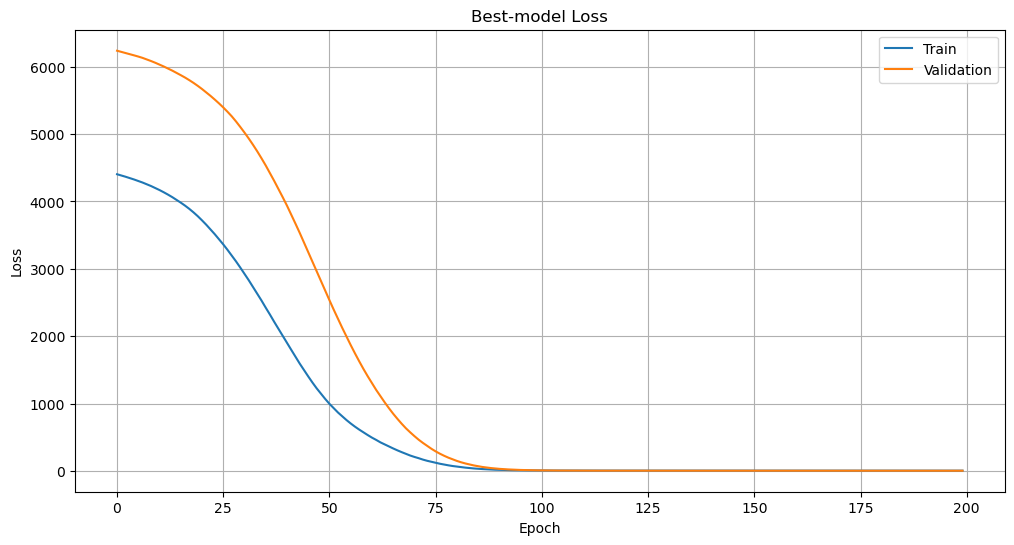

In [23]:
# Построение графиков функции потерь
plt.figure(figsize=(12, 6))
plt.plot(best_history.history['loss'])
plt.plot(best_history.history['val_loss'])
plt.title('Best-model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(True)
plt.show()

In [24]:
print('R2_best:', best_r2.round(5))
print('Число нейронов на слое 1 для лучшей модели:', best_num_neurons_1)
print('Число нейронов на слое 2 для лучшей модели:', best_num_neurons_2)
print('Значение seed для best-модели:', best_seed)

R2_best: 0.9816
Число нейронов на слое 1 для лучшей модели: 20
Число нейронов на слое 2 для лучшей модели: 24
Значение seed для best-модели: 1910


In [25]:
y_NN_pred = best_model.predict(X_test_std)
y_NN_pred_train = best_model.predict(X_train_std)

rmse_NN_train = np.sqrt(mean_squared_error(y_train, y_NN_pred_train)).round(3)
rmse_NN_test = np.sqrt(mean_squared_error(y_test, y_NN_pred)).round(3)
mae_NN_train = mean_absolute_error(y_train, y_NN_pred_train).round(3)
mae_NN_test = mean_absolute_error(y_test, y_NN_pred).round(3)
r2_NN_train = r2_score(y_train, y_NN_pred_train).round(3)
r2_NN_test = r2_score(y_test, y_NN_pred).round(3)

b_max_NN = best_model.predict(A_max_std)[:].flatten()
b_max_NN_complex = complex(b_max_NN[0], b_max_NN[1])
b_max_NN_modul = np.abs(b_max_NN_complex)
b_max_NN_arg = np.angle(b_max_NN_complex) * 180 / np.pi
metrics['NeuralNet_best'] = (str(r2_NN_train), str(r2_NN_test), np.round(b_max_NN_complex, 1), str(b_max_NN_modul.round(1)), str(b_max_NN_arg.round(1)))

2/2 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 22ms/step


In [26]:
print(f'Метрики для best-модели:')
print(f'RMSE train: {rmse_NN_train}')
print(f'RMSE test:  {rmse_NN_test}')
print()
print(f'MAE train:  {mae_NN_train}')
print(f'MAE test:   {mae_NN_test}')
print()
print(f'R2 train:   {r2_score(y_train, y_NN_pred_train).round(6)}')
print(f'R2 test:    {r2_score(y_test, y_NN_pred).round(6)}')
print()
print(f'Прогноз целевой переменной:')
print(f'b max_complex_best:    {np.round(b_max_NN_complex, 1)}')
print(f'b max_modul_best:      {b_max_NN_modul.round(1)}')

Метрики для best-модели:
RMSE train: 2.292
RMSE test:  2.261

MAE train:  1.977
MAE test:   1.926

R2 train:   0.982464
R2 test:    0.981601

Прогноз целевой переменной:
b max_complex_best:    (174.3+279.6j)
b max_modul_best:      329.5


13. Условно точный прогноз целевой переменной b

In [27]:
b_max_acc_complex = np.dot(np.array(A_complex_max), np.array(z_complex_acc)).round(3)
b_max_acc_modul = abs(b_max_acc_complex).round(3)
b_max_acc_arg = np.angle(b_max_acc_complex) * 180 / np.pi
metrics['Accurate'] = ('', '', str(b_max_acc_complex[0].round(1)), str(b_max_acc_modul[0].round(1)), str(b_max_acc_arg[0].round(1)))

print(f'Условно точный прогноз целевой переменной по известным точным коэффициентам регрессии:')
print(f'b_max_acc_complex: {b_max_acc_complex[0]}')
print(f'b_max_acc_modul: {b_max_acc_modul[0]}')

Условно точный прогноз целевой переменной по известным точным коэффициентам регрессии:
b_max_acc_complex: (147.1+303.7j)
b_max_acc_modul: 337.449


14. Сводная таблица метрик и прогнозов моделей

In [28]:
df_metrics = pd.DataFrame(metrics)
df_metrics.index = ['R2 train', 'R2 test', 'b_max_complex', 'b_max_modul', 'b_max_arg, DEG']
df_metrics = df_metrics.astype(object)
df_metrics

,LinearRegr,Ridge,Lasso,ElasticNet,TheilSenRegr,Mean,NeuralNet_best,Accurate
R2 train,1.0,1.0,1.0,1.0,1.0,1.0,0.982,
R2 test,1.0,1.0,1.0,1.0,1.0,1.0,0.982,
b_max_complex,(147.3+303.9j),(147.4+304.1j),(201+322.3j),(168.1+341.4j),(148.5+305.7j),(162.5+315.5j),(174.3+279.6j),(147.1+303.7j)
b_max_modul,337.7,337.9,379.8,380.5,339.8,354.9,329.5,337.4
"b_max_arg, DEG",64.1,64.1,58.1,63.8,64.1,62.8,58.1,64.2
